<a href="https://colab.research.google.com/github/vivitc/deep-learning-books/blob/master/Trabalho_DL_Books.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabalho Deep Learning - Filtragem colaborativa com avaliações de livros**
## Grupo 7
### - Amanda
### - James La Rosa
### - Roger William Calderini
### - Vinícius D`Ambros
### - Viviana Terceros Cordova

Neste notebook, desenvolveremos o trabalho com foco em: 
- Filtragem Colaborativa
- Cold Start

Com isso, busca-se desenvolver um modelo de recomendação que leve em consideração a filtragem colaborativa (avaliações de cada usuário) e drible o cold start identificado.

## 0. Importação das bibliotecas

Upload das bibliotecas que serão utilizadas

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.datasets import mnist

#Visualização
import seaborn as sns
sns.set(style='white', context='notebook', palette='pastel')
#Visualização dos dados
import matplotlib.pyplot as plt

#Used for distribution fitting, and representation
from scipy import stats

#Time measuring for model training
from time import time

#dependência do matplotlib
!pip install msgpack 
#instalação do pacote matplotlib
!pip install matplotlib  
import matplotlib.pyplot as plt 
import pandas as pd  
import statsmodels.api as sm  
import pylab as pl  
import numpy as np  
from patsy import dmatrix  

!pip install wordcloud
from os import path
from PIL import Image

import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Upload da base

Aqui, vamos subir a base 

In [4]:
import pandas as pd  
url_book_rating = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Book-Ratings01.csv'
df_book_rating = pd.read_csv(url_book_rating, delimiter=";", encoding="latin1")

In [5]:
display(df_book_rating)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [6]:
import pandas as pd  
url_book = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Books01.csv'
df_book = pd.read_csv(url_book, delimiter=";", encoding="latin1")

In [7]:
display(df_book)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271374,440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271375,525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271377,192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [8]:
import pandas as pd  
url_users = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Users01.csv'
df_users = pd.read_csv(url_users, delimiter=";", encoding="latin1", header=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
display(df_users)

,User-ID,Location_CT,Location_UF,Location_CY,Age
0,120567,545,rheinland-pfalz,germany,NaN
1,84244,01109,sachsen,germany,40.0
2,151969,1700,fribourg,switzerland,24.0
3,147786,01721,NaN,NaN,37.0
4,160922,3003,tenerife,espaã±a,30.0
...,...,...,...,...,...
277659,257484,zwolle,overijssel,netherlands,25.0
277660,258249,zwolle,NaN,netherlands,26.0
277661,239223,zxcvzxcvzxcvz,abruzzo,italy,32.0
277662,146905,zywiec,slaskie,poland,22.0


## 2. Análise descritiva dos dados
Em seguida, vamos fazer alguns pré-processamentos básicos para conhecer os dados, lembrando os códigos:
- BX-Users: Contém os usuários(`User-ID`) anônimos. Dados demográficos organizados, quando disponíveis (`Location`, `Age`). `Age` com valor NaN, significa que o valor de `Age` nao foi disponibilizado.

- BX-Books: Os livros são identificados pelo ISBN (os inválidos já foram removidos). Informações sobre conteúdo são disponíveis como (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), pelo Amazon Web Services. Se houver mais de 1 autor, só o primeiro é mencionado. Imagens da capa estão disponíveis em pequeno, médio e grande (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), pelo Amazon Web Services também.

- BX-Book-Ratings: As avaliações dos livros (`Book-Rating`)  são ou explícitas de 1-10 (valores mais altos indicam mais apreciação), ou implicito, expresso por 0.

### *Apesar da base ter diversos países e avaliações, testamos a análise descritiva dos dados e a Filtragem Colaborativa com os dados completos e recebemos uma mensagem de erro devido ao tamanho da Matriz de Interação:*

*Erro: ValueError: Unstacked DataFrame is too big, causing int32 overflow*

*Assim, foram feitos alguns recortes na base para que seja possível trabalhá-la, sendo:*
- *Utilização dos dados referente ao Country USA;*
- *Utilização de livros com avaliações explícitas, ou seja, Ratings de 1-10.*

###2.1 Users (aguardando normalização)

In [10]:
#Verificando as estatísticas básicas
df_users.describe

<bound method NDFrame.describe of        User-ID    Location_CT                   Location_UF  Location_CY   Age
0       120567            545               rheinland-pfalz      germany   NaN
1        84244          01109                       sachsen      germany  40.0
2       151969           1700                      fribourg  switzerland  24.0
3       147786          01721                           NaN          NaN  37.0
4       160922           3003                      tenerife      espaã±a  30.0
...        ...            ...                           ...          ...   ...
277659  257484         zwolle                    overijssel  netherlands  25.0
277660  258249         zwolle                           NaN  netherlands  26.0
277661  239223  zxcvzxcvzxcvz                       abruzzo        italy  32.0
277662  146905         zywiec                       slaskie       poland  22.0
277663   51181          zzzzz  australian capital territory          usa   NaN

[277664 rows x 5 

In [11]:
#Entendendo se temos muitos valores faltantes
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277664 entries, 0 to 277663
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      277664 non-null  object 
 1   Location_CT  277060 non-null  object 
 2   Location_UF  262401 non-null  object 
 3   Location_CY  273966 non-null  object 
 4   Age          166320 non-null  float64
dtypes: float64(1), object(4)
memory usage: 10.6+ MB


In [12]:
total = df_users.isnull().sum().sort_values(ascending = False)
percent = (df_users.isnull().sum()/df_users.isnull().count()*100).sort_values(ascending = False)
missing_df_users  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_users

,Total,Percent
Age,111344,40.100265
Location_UF,15263,5.496932
Location_CY,3698,1.331826
Location_CT,604,0.217529
User-ID,0,0.000000


24.0    5646
25.0    5587
26.0    5462
23.0    5421
27.0    5286
28.0    5251
29.0    5198
32.0    4739
30.0    4733
22.0    4663
33.0    4649
34.0    4617
31.0    4615
21.0    4405
35.0    4144
20.0    4029
19.0    3921
36.0    3867
18.0    3674
37.0    3550
Name: Age, dtype: int64

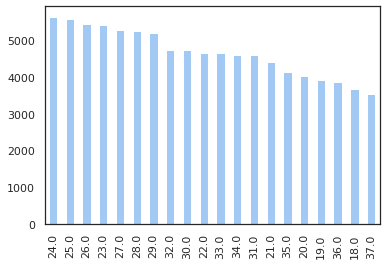

In [13]:
# Ratings de 0 a 10
Users_Age=df_users["Age"].value_counts(ascending=False)
Users_Age.head(20).plot.bar()
Users_Age.head(20)



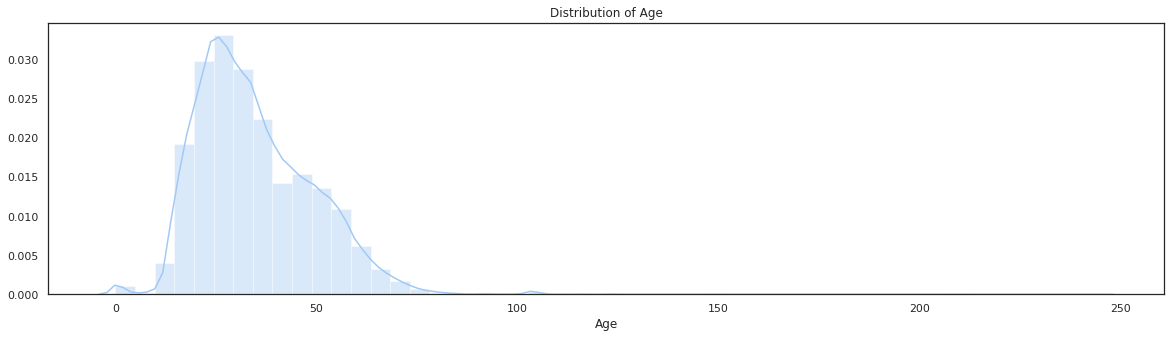

In [14]:
#Histograma com distribuição de idade
plt.figure(figsize=(20,5))
plt.title("Distribution of Age")
ax = sns.distplot(df_users["Age"])

###2.2 Books

In [15]:
#Verificando as estatísticas básicas
df_book.describe(exclude=[np.object])

,Year-Of-Publication
count,271379.000000
mean,1959.763394
std,257.983943
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


In [16]:
#Entendendo se temos muitos valores faltantes
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


2002    17628
1999    17432
2001    17360
2000    17235
1998    15767
1997    14892
2003    14359
1996    14031
1995    13548
1994    11796
1993    10603
1992     9906
1991     9389
1990     8661
1989     7937
1988     7493
1987     6529
1986     5841
2004     5839
1985     5343
Name: Year-Of-Publication, dtype: int64

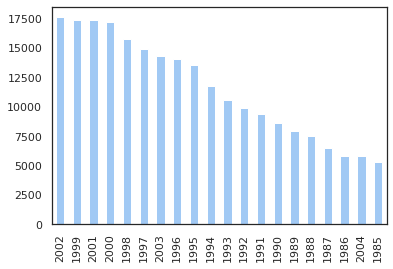

In [17]:
# Anos de publicação Top 20
Ratings=df_book["Year-Of-Publication"].value_counts(ascending=False)
Ratings.head(20).plot.bar()
Ratings.head(20)



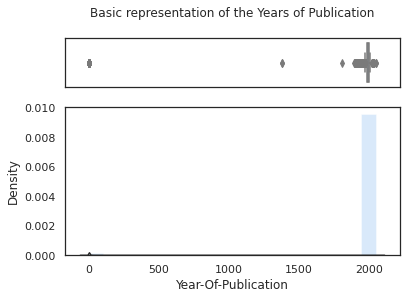

In [18]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book["Year-Of-Publication"], ax=ax_box).set_title("Basic representation of the Years of Publication\n")
sns.distplot(df_book["Year-Of-Publication"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [19]:
Q3 = np.quantile(df_book["Year-Of-Publication"], 0.75) #Third quartile
Q1 = np.quantile(df_book["Year-Of-Publication"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book[df_book["Year-Of-Publication"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df_book_rating["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

Number of outliers: 17 
Outlier proportion: 0.001 % 
Outlier threshold score: 2016.5 / 100


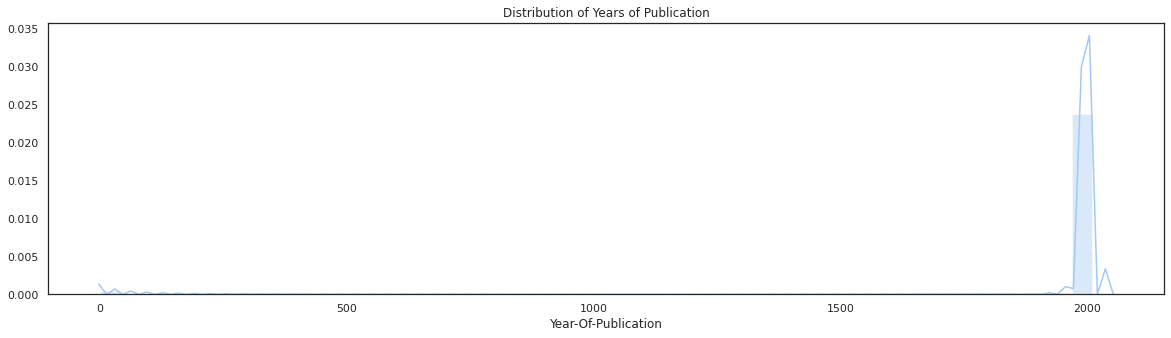

In [20]:
#Histograma com distribuição dos anos de publicação
plt.figure(figsize=(20,5))
plt.title("Distribution of Years of Publication")
ax = sns.distplot(df_book["Year-Of-Publication"])

###2.3 Books Ratings

In [21]:
#Verificando as estatísticas básicas
df_book_rating.describe(exclude=[np.object])

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [22]:
#Entendendo se temos muitos valores faltantes
df_book_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [23]:
total = df_book_rating.isnull().sum().sort_values(ascending = False)
percent = (df_book_rating.isnull().sum()/df_book_rating.isnull().count()*100).sort_values(ascending = False)
missing_df_book_rating  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_book_rating

,Total,Percent
Book-Rating,0,0.0
ISBN,0,0.0
User-ID,0,0.0


0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
Name: Book-Rating, dtype: int64

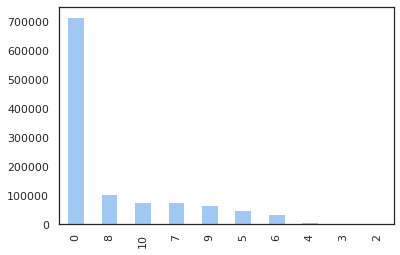

In [24]:
# Ratings de 0 a 10
Ratings=df_book_rating["Book-Rating"].value_counts(ascending=False)
Ratings.head(10).plot.bar()
Ratings.head(10)



In [25]:
total = df_book_rating["Book-Rating"].value_counts(ascending=False)
percent = (df_book_rating.count()/df_book_rating.count()*100).sort_values(ascending = False)
Ratings_percent  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
Ratings_percent

,Total,Percent
0,716109.0,NaN
1,1770.0,NaN
2,2759.0,NaN
3,5996.0,NaN
4,8904.0,NaN
5,50974.0,NaN
6,36924.0,NaN
7,76457.0,NaN
8,103736.0,NaN
9,67541.0,NaN


# Filtro Levando em consideração pessoas que tem mais do que 1 avaliação!

0     693560
8      93861
10     72589
7      69618
9      62396
5      47476
6      33671
4       8031
3       5391
2       2461
Name: Book-Rating, dtype: int64

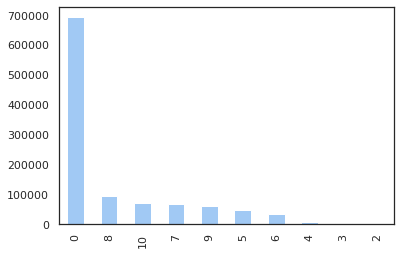

In [54]:
#display(df_book_rating[df_book_rating.groupby().count()] > 1])

df1 = df_book_rating[df_book_rating["User-ID"].map(df_book_rating["User-ID"].value_counts()) > 1]


Ratings=df1["Book-Rating"].value_counts(ascending=False)
Ratings.head(10).plot.bar()
Ratings.head(10)

In [ ]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book_rating["Book-Rating"], ax=ax_box).set_title("Basic representation of the Score feature\n")
sns.distplot(df_book_rating["Book-Rating"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [ ]:
Q3 = np.quantile(df_book_rating["Book-Rating"], 0.75) #Third quartile
Q1 = np.quantile(df_book_rating["Book-Rating"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book_rating[ df_book_rating["Book-Rating"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df_book_rating["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

In [ ]:
#Histograma com distribuição dos Ratings
plt.figure(figsize=(20,5))
plt.title("Distribution of Ratings")
ax = sns.distplot(df_book_rating["Book-Rating"])

## 3. Desenvolvimento do Cold Start
Estruturar como vamos resolver o problema de cold start

## 4. Desenvolvimento Filtragem Colaborativa
Executaremos a filtragem com DL e sem DL, para depois compararmos as principais métricas:
- MF Accuracy
- F1-score
- Precision
- Recall
- MSE: O loss é root mean squared error loss 
- mean_abs_error: O mean absolute error


### 4.1 - F.C. sem Deep Learning

In [ ]:
df_users['Location_CY'] = df_users['Location_CY'].str.strip()
df_users

In [ ]:
df_users = df_users.dropna(subset=['Age'])
df_users

In [ ]:
import numpy as np
df_users_usa = df_users[(df_users['Location_CY'] == "usa")]
df_users_usa

In [ ]:
df_book_rating_no_empty = df_book_rating[(df_book_rating['Book-Rating'] > 0)]
df_book_rating_no_empty

In [ ]:
import numpy as np
df_book_rating_no_empty['Recommend'] = np.where((df_book_rating_no_empty['Book-Rating'] > 6), 1, 0)
df_book_rating_no_empty

In [ ]:
merged_user_book_rating_df = pd.merge(left=df_users_usa, right=df_book_rating_no_zero, left_on='User-ID', right_on='User-ID')
merged_user_book_rating_df

In [ ]:
#https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929
import sklearn as sk
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
merged_user_book_rating_df['userUniq'] = user_enc.fit_transform(merged_user_book_rating_df['User-ID'].values)
n_users = merged_user_book_rating_df['userUniq'].nunique()

book_enc = LabelEncoder()
merged_user_book_rating_df['bookUniq'] = book_enc.fit_transform(merged_user_book_rating_df['ISBN'].values)
n_books = merged_user_book_rating_df['bookUniq'].nunique()

merged_user_book_rating_df['Book-Rating'] = merged_user_book_rating_df['Book-Rating'].values.astype(np.float32)
min_rating = min(merged_user_book_rating_df['Book-Rating'])
max_rating = max(merged_user_book_rating_df['Book-Rating'])

n_users, n_books, min_rating, max_rating

In [ ]:
from sklearn.model_selection import train_test_split

X = merged_user_book_rating_df[['userUniq', 'bookUniq']].values
y = merged_user_book_rating_df['Book-Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
def RecommenderV1(n_users, n_books, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    book = Input(shape=(1,))
    m = Embedding(n_books, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(book)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, book], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderV1(n_users, n_books, n_factors)
model.summary()

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

O codigo de abaixo foi tenanto usar pivotal de pandas para criar a matrix, como uma outra forma de fazere a filtragem colaborativa, mais ainda esta em progresso

In [ ]:
reviews_dict = merged_user_book_rating_df.groupby(['User-ID','ISBN'])['Recommend'].apply(list).to_dict()
reviews_dict

In [ ]:
reviews_matrix = merged_user_book_rating_df.groupby(['User-ID','ISBN'])['Book-Rating'].max().unstack()
reviews_matrix

In [ ]:
user_books_matrix_df = merged_user_book_rating_df.pivot(index='User-ID',
                                                     columns='ISBN',
                                                     values='Book-Rating').fillna(0)

In [ ]:
user_books_matrix_df.head(10)

### 4.2 - F.C. com Deep Learning

## 5. Comparativo e análise
Verificamos as principais métricas dos dois algoritmos, comparando e identificando diferenças

## 6. Conclusão
Fechamos o trabalho com a percepção final sobre os 2 modelos executados.